In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

#### 0. Przygotowanie Danych

In [2]:
test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv', index_col=0)
train_df = pd.read_csv('data/UNSW_NB15_training-set.csv', index_col=0)

Podział danych na treningowe, testowe i walidacyjne

In [4]:
val_df, test_df = train_test_split(test_df, random_state=710, test_size=0.3)

In [5]:
X_train = train_df.drop(columns=['label', 'attack_cat'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label', 'attack_cat'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label', 'attack_cat'])
y_test = test_df['label']

In [6]:
numeric_columns = X_train.select_dtypes('number').columns
categorical_columns = X_train.select_dtypes('object').columns

#### 1. Feature Engineering

In [ ]:
mi = mutual_info_classif(X_train[numeric_columns], y_train)
mi = pd.Series(data = mi, index = numeric_columns)

Poniżej mamy funkcję do usuwania zmiennych silnie skorelowanych w lepszy niż losowy sposób.

To znaczy staramy się wpierw usuwać te najmniej znaczące.

In [8]:
def remove_correlated_features(X, y = None, threshold = 0.65, features=numeric_columns, mi = None, corr_df = None):
    # at least one of 'y' and 'mi' must be not None
    assert(y is not None or mi is not None)
    if mi is None:
        mi = pd.Series(data = mutual_info_classif(X[features], y), index=features)
    if corr_df is None:
        corr_df = X.corr()

    # convert to an easier to use data frame
    corr_df = corr_df.melt(ignore_index=False).\
        reset_index(drop=False).\
        rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})

    # we look for all pairs of (different) features that are highly correlated
    corr_df = corr_df[
                (np.abs(corr_df['Corr']) > threshold) & 
                (corr_df['Var 1'] != corr_df['Var 2'])
        ].\
        sort_values(by='Corr', ascending=False)

    removed_features = set()

    # ALGORYTM 2
    # usuwamy atrybuty od najmniej ważnych tak długo jak są pary silnie skorelowane

    mi = mi.sort_values()
    correlated_features = set(corr_df['Var 1']).union(set(corr_df['Var 2']))

    i = 0 
    while corr_df.shape[0] > 0 and i < mi.shape[0]:
        feature = mi.index[i]
        i += 1
        if feature not in correlated_features:
            continue
        correlated_features.remove(feature)
        removed_features.add(feature)
        corr_df = corr_df[(corr_df['Var 1'] != feature) & (corr_df['Var 2'] != feature)]

    return X.drop(list(removed_features), axis=1), list(removed_features)

In [12]:
X_train_reduced = remove_correlated_features(X_train, mi=mi)[0]
uncorrelated_columns = X_train_reduced.columns # to się przyda na potem

#### 2. Przygotowanie Pipelineów

Poniżej definiujemy kilka klas, które używamy przy budowaniu naszych Pipelineów.

In [13]:
class ColumnSelectorTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X[self.columns]

    def fit(self, X, y=None):
        return self

In [14]:
numeric_transformer = Pipeline(
                        steps=[
                            ("scaler", StandardScaler())
                        ]
                      )

categorical_transformer = OneHotEncoder(drop='first')

def create_column_transformer(columns_to_use):
    numeric_columns_to_use = np.intersect1d(columns_to_use, numeric_columns)
    categorical_columns_to_use = np.intersect1d(columns_to_use, categorical_columns)
    
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_columns_to_use),
            ("cat", categorical_transformer, categorical_columns_to_use),
        ]
    )

In [15]:
# columns_to_use = ['ct_dst_sport_ltm', 'sttl', 'dload', 'ct_state_ttl', 'dmean']
columns_to_use = np.intersect1d(uncorrelated_columns, mi.sort_values(ascending=False).index[:6])

#### 2.1 Przygotowanie Modelu XGBoost

In [49]:
preprocessor = Pipeline(
    steps=[
        ("column_selector", ColumnSelectorTransformer(columns=columns_to_use)),
        ("column_transformer", create_column_transformer(columns_to_use)),
    ]
)

xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=710, eval_metric='logloss', use_label_encoder=False))
    ]
)

#### 3. Strojenie hiperparametrów

In [50]:
xgb_parameters = {'classifier__n_estimators' : [x for x in range(1,5000,250)],
                  'classifier__learning_rate' : [2**x for x in range(-10,0,1)],
                  'classifier__subsample' : [x/10 for x in range(1,11)],
                  'classifier__max_depth' : [x for x in range(1,16)],
                  'classifier__min_child_weight' : [2**x for x in range(0,8)],
                  'classifier__reg_lambda' : [2**x for x in range(-10,11)],
                  'classifier__reg_alpha' : [2**x for x in range(-10,11)]}

In [54]:
clf = RandomizedSearchCV(xgb_clf,
                         param_distributions=xgb_parameters,
                         cv=3,
                         n_jobs=-1,
                         n_iter=500,
                         scoring = 'roc_auc',
                         random_state=710,
                         verbose = 1
                        )

In [55]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed: 120.4min


KeyboardInterrupt: 

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

In [ ]:
tuning_results=pd.DataFrame(clf.cv_results_)
tuning_results.to_csv("tuning_results.csv")

In [ ]:
tuning_results = pd.read_csv("tuning_results.csv")

#### 4. Ewaluacja Modelu

Sprawdzimy skuteczność znalezionego modelu.

In [59]:
# funkcja pomocnicza do ewaluacji modelu

def statistics_classification(y, y_pred, y_pred_proba):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    axes[0].set_title('ROC curve')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    # plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not an attack)', '1 (Attack)'], yticklabels=['0 (Not an attack)', '1 (Attack)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix')
    plt.show()

    # display metrics
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    matthews_coef = matthews_corrcoef(y, y_pred)

    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{matthews_coef=}')

fitted


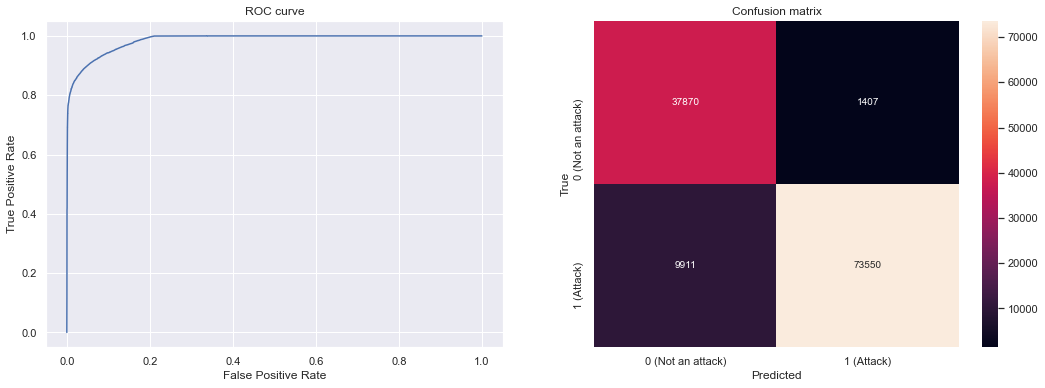

accuracy=0.9077873193306066
recall=0.8812499251147242
f1=0.9285560984231589
matthews_coef=0.8088231387278811


In [60]:
xgb_clf.fit(X_train, y_train)
print("fitted")
y_pred = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)